# Conditional GANs

Based on the excellent tutorial [here](https://github.com/Yangyangii/GAN-Tutorial/blob/master/MNIST/Conditional-GAN.ipynb).

By formulating the process as a two-player game, Generative Adversarial Networks (GANs) can be very effective in generating realistic content. However, we may want to have more control over what is generated. Conditional GANs offer more control by letting us specify the *class* of output we want. Then we hand the generated content and the class it's supposed to be to the discriminator. The disciminator attempts to differentiate between the generated content of a certain class and the real content of a certain class.

The original paper that described conditional GANs is [here](https://arxiv.org/abs/1411.1784).

## Libaries

As always, we load lots of libraries.

In [3]:
import torch
from torchvision import datasets
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
import numpy as np
import os
from matplotlib.pyplot import imsave
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## Data

For this demo, we will be using the MNIST data set. We can apply GANs to other datasets but the training process takes much longer. Our goal will be to supply random noise and a class label (e.g. a digit between 0 and 9) to the generator and produce an image of that particular digit.

In [4]:
# A transform to convert the images to tensor and normalize their RGB values
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5], std=[0.5])]
)

data = datasets.MNIST(root='../data/', train=True, transform=transform, download=True)

batch_size = 64
data_loader = DataLoader(dataset=data, batch_size=batch_size, shuffle=True, drop_last=True)

## Helper Functions

We'll need several helper functions for training the conditional GAN. The first converts labels to one hot encoded vectors, we will use it to pass the desired label to the generator. The second will plot a grid of 10x10 images from the generator.

In [5]:
def to_onehot(x, num_classes=10):
    assert isinstance(x, int) or isinstance(x, (torch.LongTensor, torch.cuda.LongTensor))
    if isinstance(x, int):
        c = torch.zeros(1, num_classes).long()
        c[0][x] = 1
    else:
        x = x.cpu()
        c = torch.LongTensor(x.size(0), num_classes)
        c.zero_()
        c.scatter_(1, x, 1) # dim, index, src value
    return c

In [ ]:
to_onehot(3)

tensor([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]])

In [7]:
def get_sample_image(G, DEVICE, n_noise=100):
    img = np.zeros([280, 280])
    for j in range(10):
        c = torch.zeros([10, 10]).to(DEVICE)
        c[:, j] = 1
        z = torch.randn(10, n_noise).to(DEVICE)
        y_hat = G(z,c).view(10, 28, 28)
        result = y_hat.cpu().data.numpy()
        img[j*28:(j+1)*28] = np.concatenate([x for x in result], axis=-1)
    return img

## Architecture

We now instantiate the generator and discriminator architectures. The generator takes a random noise vector and a one hot encoded label as input and produces an image. The discriminator takes an image and a one hot encoded label as input and produces a single value between 0 and 1. The discriminator is trained to output 1 for real images and 0 for fake images. The generator is trained to fool the discriminator by outputting images that look real.

In [8]:
class Generator(nn.Module):
    def __init__(self, input_size=100, num_classes=10, image_size=28*28):
        super(Generator, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size+num_classes, 128), # auxillary dimension for label
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, image_size),
            nn.Tanh()
        )
        
    def forward(self, x, c):
        x, c = x.view(x.size(0), -1), c.view(c.size(0), -1).float()
        v = torch.cat((x, c), 1) # v: [input, label] concatenated vector
        y_ = self.network(v)
        y_ = y_.view(x.size(0), 1, 28, 28)
        return y_

In [9]:
class Discriminator(nn.Module):
    def __init__(self, input_size=28*28, num_classes=10, num_output=1):
        super(Discriminator, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size+num_classes, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, num_output),
            nn.Sigmoid(),
        )
    
    def forward(self, x, c):        
        x, c = x.view(x.size(0), -1), c.view(c.size(0), -1).float()
        v = torch.cat((x, c), 1) # v: [input, label] concatenated vector
        y_ = self.network(v)
        return y_

## Set up and Training

Now, we're ready to instantiate our models, hyperparameters, and optimizers. Since the task is so easy for MNIST, we will train for only 10 epochs. We will update the generator and discriminator in every step but often one can be trained more frequently than the other.

In [10]:
MODEL_NAME = 'ConditionalGAN'
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

D = Discriminator().to(DEVICE)
G = Generator().to(DEVICE)

max_epoch = 10
step = 0
n_noise = 100 # size of noise vector

criterion = nn.BCELoss()
D_opt = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
G_opt = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

# We will denote real images as 1s and fake images as 0s
# This is why we needed to drop the last batch of the data loader
D_labels = torch.ones([batch_size, 1]).to(DEVICE) # Discriminator label: real
D_fakes = torch.zeros([batch_size, 1]).to(DEVICE) # Discriminator Label: fake

In [11]:
images, labels = next(iter(data_loader))
y = labels.view(batch_size, 1)
y = to_onehot(y).to(DEVICE)
print(labels[:10])
print(y[:10])

tensor([5, 7, 6, 1, 6, 1, 1, 4, 4, 8])
tensor([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]])


In [12]:
# a directory to save the generated images
if not os.path.exists('samples'):
    os.makedirs('samples')

for epoch in range(max_epoch):
    for idx, (images, labels) in enumerate(data_loader):
      #train discriminator
      #get real images and pass them through then assign labels 1
      #get fake images and pass them through then assign labels 0
      #compute loss
      # optimize with respect to discriminator's parameters

      # train generator
      #get fake images and pass them through discriminator
      #then compute loss with respect to generators parameters

      #printing status
      #saving image

        # Training Discriminator
        x = images.to(DEVICE)
        y = labels.view(batch_size, 1) # add singleton dimension so batch_size x 1
        y = to_onehot(y).to(DEVICE)
        x_outputs = D(x, y) # input includes labels
        D_x_loss = criterion(x_outputs, D_labels) # Discriminator loss for real images

        z = torch.randn(batch_size, n_noise).to(DEVICE)
        z_outputs = D(G(z, y), y) # input to both generator and discriminator includes labels
        D_z_loss = criterion(z_outputs, D_fakes) # Discriminator loss for fake images
        D_loss = D_x_loss + D_z_loss # Total Discriminator loss
        
        D.zero_grad()
        D_loss.backward()
        D_opt.step()
        
        # Training Generator
        z = torch.randn(batch_size, n_noise).to(DEVICE)
        z_outputs = D(G(z, y), y)
        G_loss = -1 * criterion(z_outputs, D_fakes) # Generator loss is negative disciminator loss

        G.zero_grad()
        G_loss.backward()
        G_opt.step()
        
        if step % 500 == 0:
            print('Epoch: {}/{}, Step: {}, D Loss: {}, G Loss: {}'.format(epoch, max_epoch, step, D_loss.item(), G_loss.item()))
        
        if step % 1000 == 0:
            G.eval()
            img = get_sample_image(G, DEVICE, n_noise)
            imsave('samples/{}_step{}.jpg'.format(MODEL_NAME, str(step).zfill(3)), img, cmap='gray')
            G.train()
        step += 1

Epoch: 0/10, Step: 0, D Loss: 1.4048413038253784, G Loss: -0.6510474681854248
Epoch: 0/10, Step: 500, D Loss: 1.263338327407837, G Loss: -0.4754475951194763
Epoch: 1/10, Step: 1000, D Loss: 1.4941439628601074, G Loss: -0.2056351900100708
Epoch: 1/10, Step: 1500, D Loss: 1.1959880590438843, G Loss: -0.2829231023788452
Epoch: 2/10, Step: 2000, D Loss: 1.146930456161499, G Loss: -0.43064531683921814
Epoch: 2/10, Step: 2500, D Loss: 1.2310885190963745, G Loss: -0.5280541181564331
Epoch: 3/10, Step: 3000, D Loss: 1.2103912830352783, G Loss: -0.4850396513938904
Epoch: 3/10, Step: 3500, D Loss: 1.340031385421753, G Loss: -0.6984496116638184
Epoch: 4/10, Step: 4000, D Loss: 1.2455283403396606, G Loss: -0.5349127650260925
Epoch: 4/10, Step: 4500, D Loss: 1.3214484453201294, G Loss: -0.5896317362785339
Epoch: 5/10, Step: 5000, D Loss: 1.3490097522735596, G Loss: -0.9269580841064453
Epoch: 5/10, Step: 5500, D Loss: 1.3476364612579346, G Loss: -0.654116690158844
Epoch: 6/10, Step: 6000, D Loss: 1.

Now let's plot these images. At first, the generator just produces noise (as we expect).

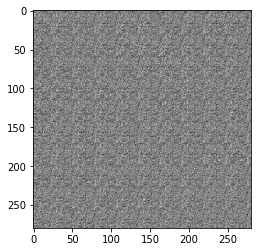

In [ ]:
img = mpimg.imread('samples/ConditionalGAN_step000.jpg')
imgplot = plt.imshow(img)
plt.show()

But then it gets better.

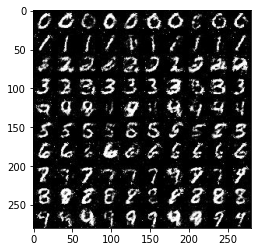

In [ ]:
img = mpimg.imread('samples/ConditionalGAN_step5000.jpg')
imgplot = plt.imshow(img)
plt.show()

In fact, if we don't look too closely, we can recognize the numbers it produces.

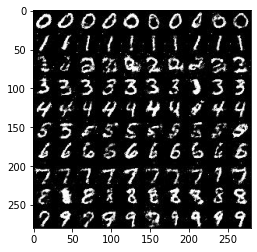

In [ ]:
img = mpimg.imread('samples/ConditionalGAN_step9000.jpg')
imgplot = plt.imshow(img)
plt.show()

And by the time we're done training, even the worst images look like messy handwriting!